# Методы снижения размерности

Довольно часто бывает так, что признаков очень много. Хочется уменьшить их число, чтобы задача по-прежнему хорошо решалась. В этом случае нам нужно будет оценивать меньше параметров в модели, и она станет более интерпретируемой: сравните линейную регрессию с двумя признаками и с пятьюстами. В каком случае понятнее, почему модель приняла то или иное решение? 

В этой тетради мы посмотрим на несколько различных способов снизить  размерность данных.


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 1. Отбор признаков

Самый простой способ выделения признаков &mdash; их отбор. Есть много разных стратегий отбора признаков: 


- __Одномерные стратегии:__ считаем, насколько сильно признаки связаны с таргетом с помощью разных метрик, оставляем только самые связанные
- __Жадные методы отбора признаков:__ надстройки над методами обучения моделей. Они перебирают различные подмножества признаков и выбирают то из них, которое дает наилучшее качество определенной модели машинного обучения. Данный процесс устроен следующим образом. Обучение модели считается черным ящиком, который на вход принимает информацию о том, какие из его признаков можно использовать при обучении модели, обучает модель, и дальше каким-то методом оценивается качество такой модели, например по отложенной выборке или кросс-валидации. Таким образом, задача, которую необходимо решить, — это оптимизация функционала качества модели по подмножеству признаков. Признаки обычно перебираются по какому-то алгоритму. Например, можно попробовать все комбинации (очень долго и неэффективно)
- __Отбор признаков на основе моделей__

Отберем признаки на основе их корреляции с целевым признаком и сравним результаты с исходными.

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

from sklearn.datasets import fetch_california_housing

Начнем с подсчета корреляции между входными и целевыми признаками для наших данных. Чем больше абсолютное значение корреляции Пирсона (чем больше линейная связь между ними), тем выше важность признака по этому критерию.

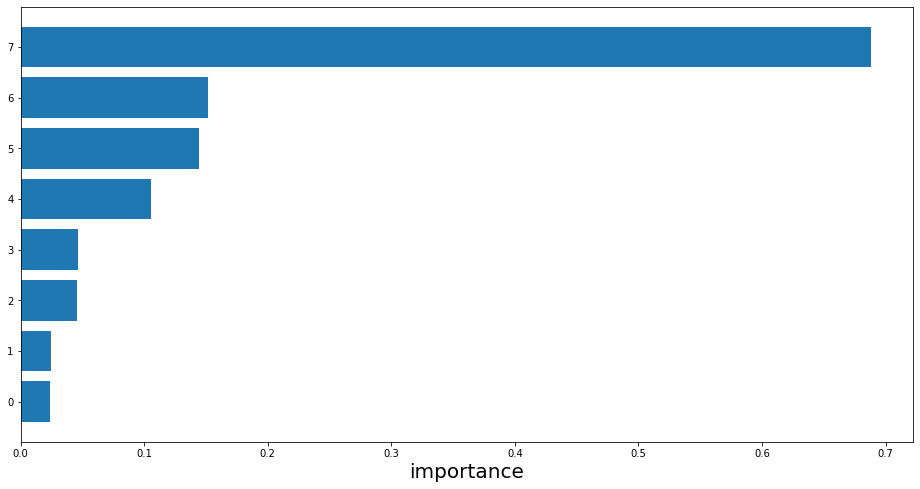

In [ ]:
# Загрузка данных
ds = fetch_california_housing()

# Получим значения входных и выходных переменных
X, y = ds.data, ds.target
indexes = np.arange(len(y))
np.random.seed(52342)
np.random.shuffle(indexes)
X = X[indexes, :]
y = y[indexes]

# Посчитаем корреляции признаков с целевой переменной
features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)

# Нарисуем полученные корреляции
fig = plt.figure(figsize=(16, 8))
plt.barh(features_ind, corrs[importances_sort])
plt.xlabel('Feature importance', fontsize=20)
plt.ylabel('Feature index', fontsize=20)
X = X[:, importances_sort]

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Теперь давайте построим модели, в которых будет разное количество входных признаков, имеющих наибольшие абсолютные значения корреляции.

In [ ]:
features_counts = np.arange(X.shape[1])

def scores_by_features_count(reg):
    scores = []
    for features_part in features_counts:
        X_part = X[:, importances_sort[features_part:]]
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_features_count(LinearRegression())
rf_scores = scores_by_features_count(RandomForestRegressor(n_estimators=100, max_depth=3))

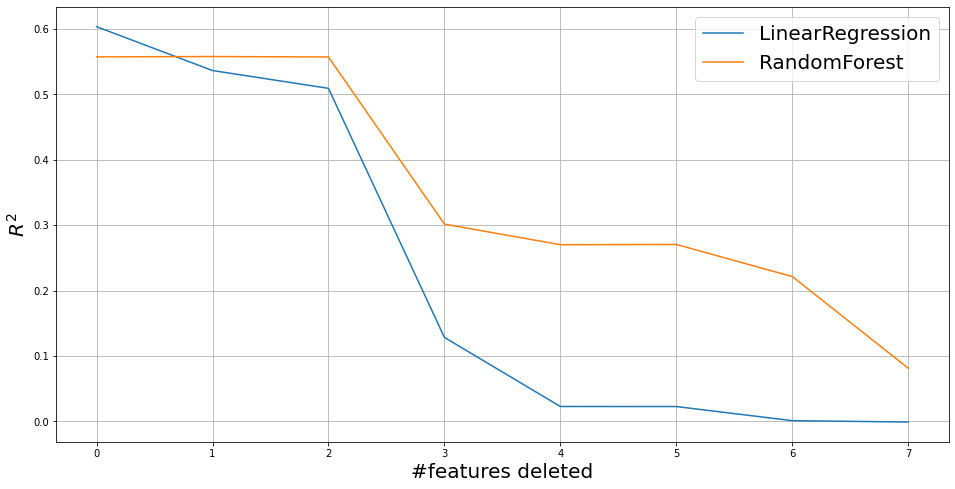

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('Number of deleted features', fontsize=20)
plt.ylabel('$R^2$ metric', fontsize=20)
plt.grid()

Если мы захотим немного сократить потребление ресурсов, пожертвовав частью качества,
видно, что это можно сделать.

Для себя можете попробовать ответить на два вопроса, подумав или написав соответствующий код:
1. Означают ли полученные результаты, что отбор признаков по корреляции лучше случайного выбора множества признаков того же размера? Какой эксперимент поможет нам понять, так это или нет?
2. Что в подобной процедуре отбора признаков может привести к переобучению? Как этого можно было бы избежать?


# 2. Метод главных компонент (Principal Component Analysis, PCA)

Выделение новых признаков путем их отбора часто дает плохие результаты, и в некоторых ситуациях такой подход практически бесполезен. Например, если мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о содержимом картинки. Поэтому признаки нужно как-то комбинировать.

__Метод главных компонент__ &mdash; один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков. В рамках метода делается два важных упрощения задачи:

1. Игнорируется целевая переменная, мы смотрим только на пространство входных признаков
2. Строится линейное преобразование исходных признаков, сохраняющее большую часть доступной информации

П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является таким уж плохим. Это связано с тем, что часто у данных есть внутренняя структура в пространстве меньшей размерности, которая никак не связана с целевой переменной. Поэтому и оптимальные признаки можно строить, не глядя на ответ.

П. 2 тоже сильно упрощает задачу, но далее мы рассмотрим и более сложные нелинейные методы.

### Теория

Вспомним, что делает этот метод.

Пусть $X$ &mdash; матрица объекты-признаки с нулевым средним каждого признака, а $w$ &mdash; некоторый единичный вектор. Тогда $Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор, который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию вдоль этого направления). Формально получаем следующую оптимизационную задачу:

$$
\max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным значением. После этого все пространство проецируется на ортогональное дополнение к вектору $w$, и процесс повторяется.

## 2.1. PCA на плоскости

Для начала посмотрим на метод PCA на плоскости, для того чтобы лучше понять, как он устроен. Попробуем специально сделать один из признаков более значимым и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного нормального распределения с нулевым математическим ожиданием. 

In [ ]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[4, 0], 
         [0, 1]],
    size=1000
)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент. В результате работы PCA из sklearn в `dec.components_` будут лежать главные направления (нормированные), а в `dec.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их значимости.

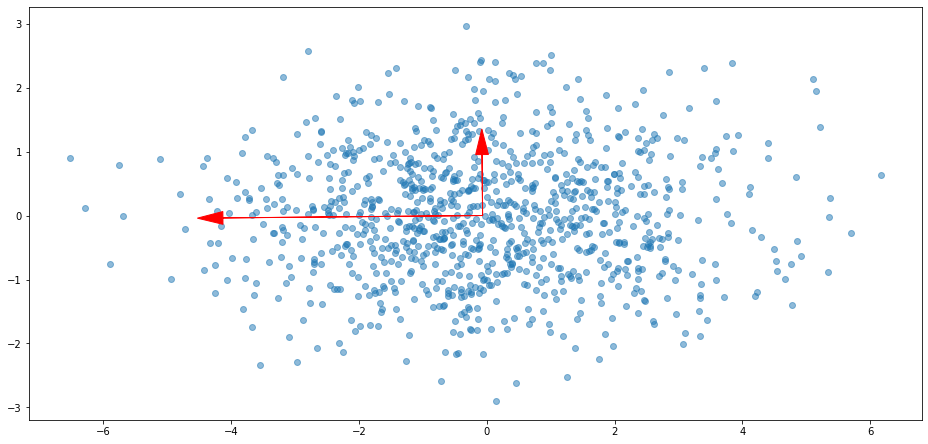

In [ ]:
from sklearn.decomposition import PCA

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

Видим, что PCA правильно выделил главные компоненты. Но это, конечно, можно было сделать и просто посчитав
дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим,
что для PCA это ничего не изменит.

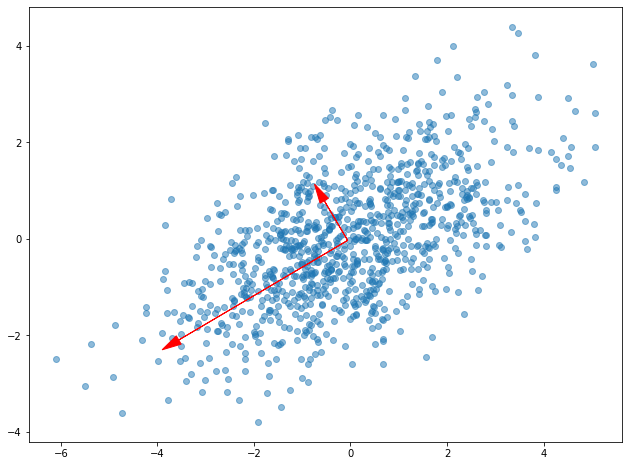

In [ ]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже — пара примеров, где PCA отработал не так хорошо, и полученные им направления задают не очень хорошие признаки.

**Упражнение:** объясните, почему так произошло.

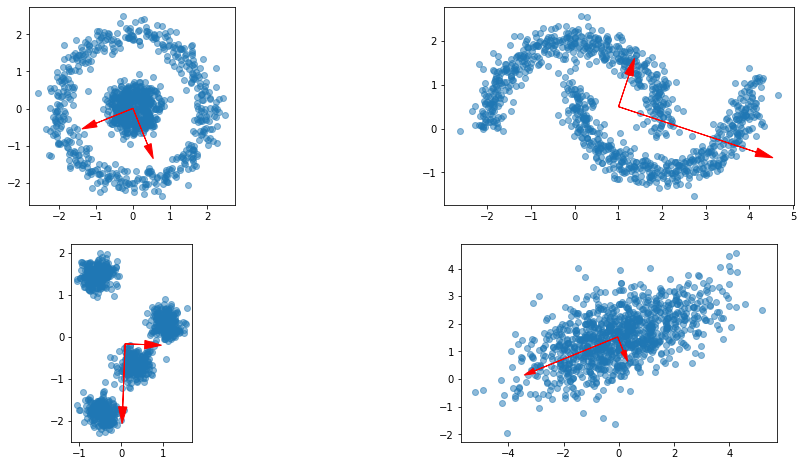

In [ ]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)

data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5], 
        cov=[[3, 1], 
             [1, 1]],
        size=1000),
]

plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

## 2.2. Лица людей

Рассмотрим датасет с фотографиями лиц людей и применим его к признакам PCA. Ниже изображены примеры лиц из базы, и последняя картинка &mdash; это «среднее лицо».

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


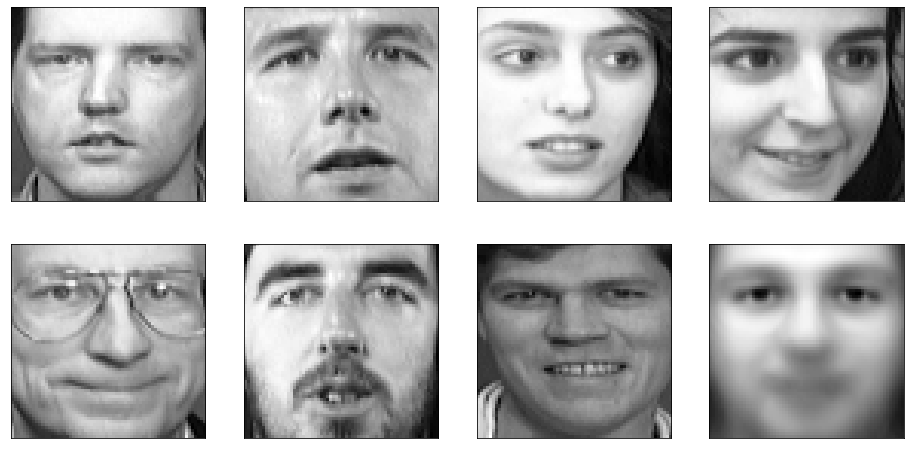

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты.

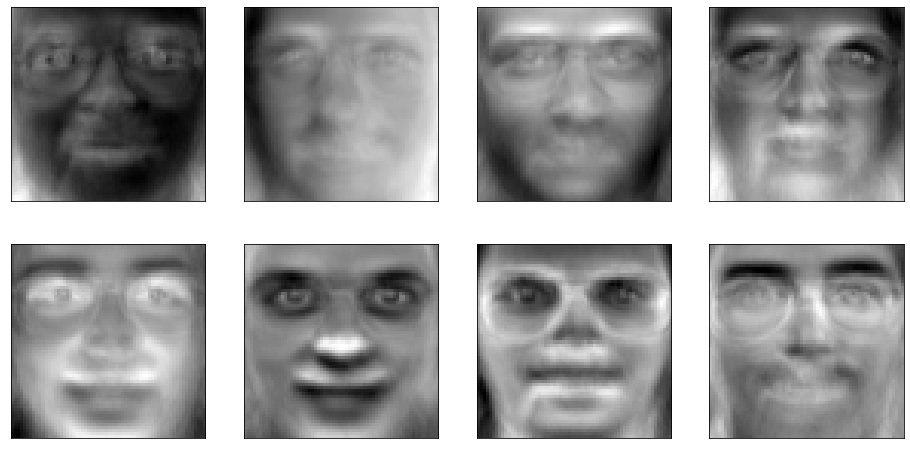

In [ ]:
model_pca = PCA()
faces_images -= mean_face  # отнормировали данные к нулевому среднему
model_pca.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(model_pca.components_[i, :].reshape(image_shape), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

- Во-первых, новые признаки дают более высокое качество классификации

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(
    RandomForestClassifier(),
    {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]}, cv=5
)

In [ ]:
%%time
gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

0.825
CPU times: user 3min 37s, sys: 562 ms, total: 3min 38s
Wall time: 3min 40s


In [ ]:
%%time
gscv_rf.fit(model_pca.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.9125
CPU times: user 1min 10s, sys: 386 ms, total: 1min 10s
Wall time: 1min 11s


На практике обычно выбирают столько главных компонент, чтобы оставить 90 % дисперсии исходных данных. В данном случае для этого достаточно выделить около 60 главных компонент, то есть можно снизить размерность с 4 096 признаков до 60, потеряв только 10 % информации!

In [ ]:
faces_images.shape

(400, 4096)

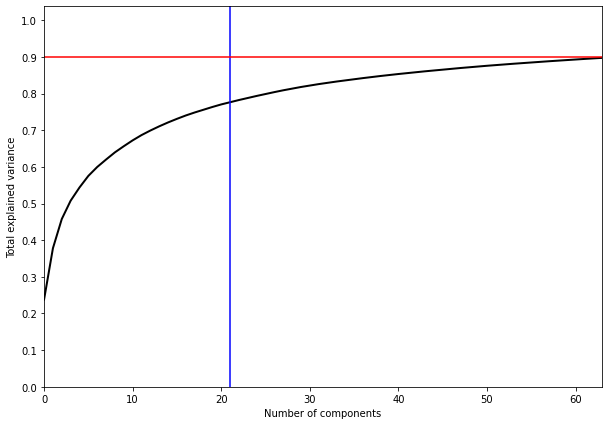

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

 - Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются в новое пространство, и из него выкидываются самые незначимые признаки. Ниже приведены результаты сжатия в 20 раз

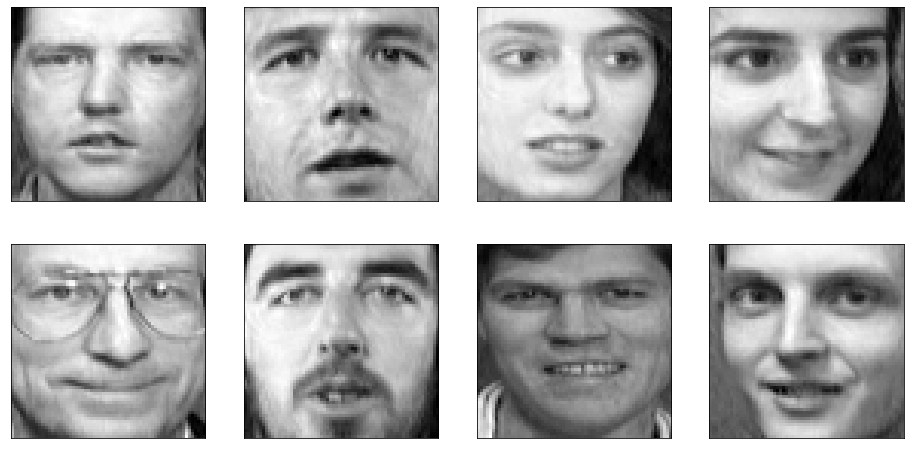

In [ ]:
base_size = image_shape[0] * image_shape[1]

def compress_and_show(compress_ratio):
    model_pca = PCA(n_components=int(base_size * compress_ratio))
    model_pca.fit(faces_images)

    faces_compressed = model_pca.transform(faces_images)
    
    # обратное преобразование
    faces_restored = model_pca.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
compress_and_show(0.05)

Даже при сжатии в 50 раз лица остаются узнаваемыми.

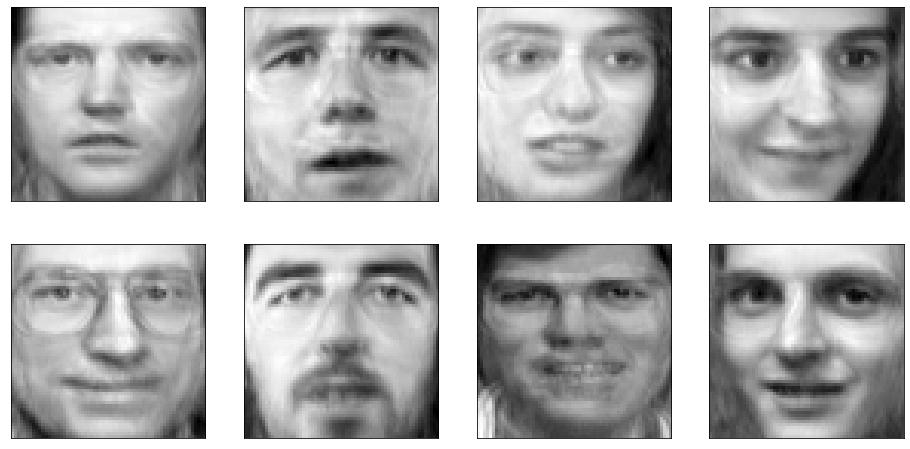

In [ ]:
compress_and_show(0.02)

## 2.3. PCA для визуализации химического состава рек

Посмотрим на еще один пример применения метода главных компонент. Будем работать с подмножеством [датасета о химическом составе воды](http://data.europa.eu/euodp/en/data/dataset/data_waterbase-rivers-10) в разных реках.  

In [ ]:
!wget https://github.com/FUlyankin/Intro_to_DS/raw/master/data/water_dataset

--2022-10-27 08:10:34--  https://github.com/FUlyankin/Intro_to_DS/raw/master/data/water_dataset
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FUlyankin/Intro_to_DS/master/data/water_dataset [following]
--2022-10-27 08:10:35--  https://raw.githubusercontent.com/FUlyankin/Intro_to_DS/master/data/water_dataset
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2188569 (2.1M) [application/octet-stream]
Saving to: ‘water_dataset’

water_dataset       100%[===================>]   2.09M  --.-KB/s    in 0.02s   

2022-10-27 08:10:35 (91.0 MB/s) - ‘water_dataset’ saved [2188569/2188569]



In [ ]:
import pickle
index_list, feature_list, data_matrix = pickle.load(open('water_dataset', 'rb'))

* `index_list` — список id рек, которые были отобраны для задания
* `feature_list` — список признаков (они имеют вид `год ПРОБЕЛ показатель`)
* `data_matrix` — собственно данные (строки соответствуют рекам из `index_list`, а столбцы — признакам из `feature_list`)

Давайте попробуем сделать PCA, визуализровать данные в пространстве первых двух компонент и проинтерпретировать первые главные компоненты. 

In [ ]:
X = data_matrix.copy()
X.shape

(500, 532)

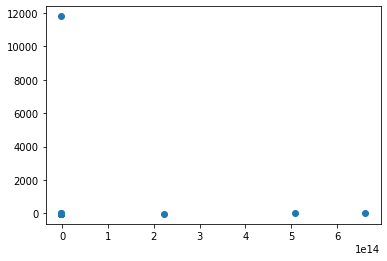

In [ ]:
from sklearn.decomposition import PCA

model_pca = PCA(10) # оставим 10 компонент
X_pca = model_pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1]);

Прямое применение PCA  к данным не дало хорошего результата:

- Вспомним, что PCA пытается выделять главные компоненты, максимизируя дисперсию. Дисперсия чувствительна к выбросам, значит, и метод главных компонент чувствителен к ним
- Судя по всему, у данных разные единицы измерения. Значит, разброс несопоставим. PCA запутался

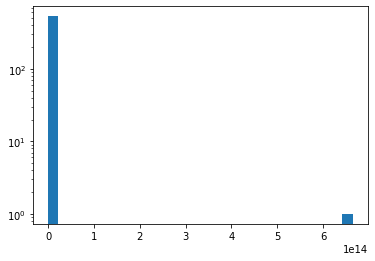

In [ ]:
plt.hist(X.max(axis=0), bins=30,log=True);

Срежем выбросы по 99 % квантилю, а затем стандартизируем данные. 

In [ ]:
replace = np.percentile(X, 99, axis=0)
for i in range(X.shape[1]):
    X[:,i][X[:,i] > replace[i]] = replace[i]

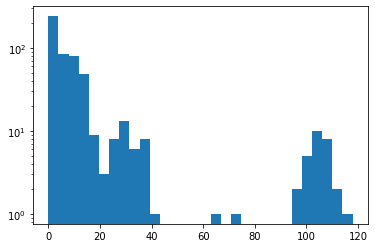

In [ ]:
plt.hist(X.max(axis=0), bins=30,log=True);

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scal = scaler.fit_transform(X)

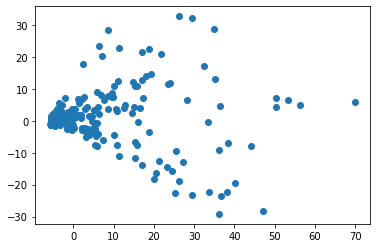

In [ ]:
model_pca = PCA(10)
X_pca = model_pca.fit_transform(X_scal)

plt.scatter(X_pca[:,0], X_pca[:,1]);

Визуализация стала лучше. Чтобы понять физический смысл первых признаков, посмотрим, из каких колонок они формируются.

In [ ]:
sorted(list(zip(feature_list, np.abs(model_pca.components_[0]))), key = lambda w : w[1], reverse=True)[:20]

[('1992 Nitrate', 0.07205514167463652),
 ('1994 Nitrate', 0.07145770940394157),
 ('1993 Nitrate', 0.06953996244973612),
 ('1990 pH', 0.06899899935368567),
 ('1994 Nitrite', 0.06892630086390454),
 ('1989 pH', 0.06879277214220082),
 ('1995 Nitrate', 0.06821782583892054),
 ('1997 Nitrate', 0.0679660058189696),
 ('1997 Dissolved oxygen', 0.06794410190616794),
 ('1992 Nitrite', 0.06791502888673775),
 ('1991 pH', 0.0677594568278405),
 ('1998 Total phosphorus', 0.0676151004162904),
 ('1992 pH', 0.06752486404460212),
 ('1993 Nitrite', 0.06748580450611903),
 ('2002 Nitrate', 0.06726143675036035),
 ('1999 Nitrate', 0.06705702189135082),
 ('2002 Total phosphorus', 0.06705015770807103),
 ('1996 Dissolved oxygen', 0.06691960685686547),
 ('1995 Nitrite', 0.06670574760873399),
 ('1998 Dissolved oxygen', 0.06654171398359399)]

In [ ]:
sorted(list(zip(feature_list, np.abs(model_pca.components_[1]))), key = lambda w : w[1], reverse=True)[:20]

[('2006 Total organic carbon (TOC)', 0.10041321449682167),
 ('2005 Total organic carbon (TOC)', 0.09772568450458813),
 ('2005 CODMn', 0.09077344156953358),
 ('2004 CODMn', 0.08934944037390745),
 ('1999 Total nitrogen', 0.08912593532340397),
 ('1996 Total organic nitrogen', 0.08896511702814074),
 ('1998 Total nitrogen', 0.08890103684332637),
 ('1997 Total nitrogen', 0.08815045390348386),
 ('2000 Total nitrogen', 0.08793498941700147),
 ('1996 Total nitrogen', 0.08785326728275297),
 ('1986 Total organic nitrogen', 0.08772444881772631),
 ('2009 CODMn', 0.08768984047796005),
 ('1995 Total nitrogen', 0.08745538919212195),
 ('2002 CODMn', 0.0872759668276825),
 ('2001 CODMn', 0.08695775051660326),
 ('1985 Total organic nitrogen', 0.08689670393447153),
 ('2009 Total organic carbon (TOC)', 0.08656463369093634),
 ('1995 Total organic nitrogen', 0.0863395971824548),
 ('2006 CODMn', 0.08616992064355704),
 ('1994 Total nitrogen', 0.08569178674510647)]

In [ ]:
sorted(list(zip(feature_list, np.abs(model_pca.components_[3]))), key = lambda w : w[1], reverse=True)[:20]

[('1989 Total inorganic nitrogen', 0.13527153141917797),
 ('1991 Total inorganic nitrogen', 0.1339142131067911),
 ('1990 Total inorganic nitrogen', 0.13350701356669095),
 ('1987 Total inorganic nitrogen', 0.13308265092572055),
 ('1988 Total inorganic nitrogen', 0.13242619223171231),
 ('1989 Total oxidised nitrogen', 0.1303788572215108),
 ('1987 Total oxidised nitrogen', 0.12953020611819926),
 ('1988 Total oxidised nitrogen', 0.12840159026903264),
 ('1990 Total oxidised nitrogen', 0.12680036717820312),
 ('1991 Total oxidised nitrogen', 0.1243874032178744),
 ('1992 Total oxidised nitrogen', 0.12270180024633467),
 ('1993 Total oxidised nitrogen', 0.11842012469743428),
 ('1994 Total oxidised nitrogen', 0.11596298321755794),
 ('1995 Total oxidised nitrogen', 0.11552744969636232),
 ('1996 Total oxidised nitrogen', 0.11252133360049944),
 ('1998 Total oxidised nitrogen', 0.10438609481564982),
 ('1987 CODMn', 0.10161880654931962),
 ('1989 CODMn', 0.10107353314398644),
 ('1999 Total oxidised nit

## 2.4. PCA с ядрами

Так как PCA фактически работает не с исходными признаками, а с матрицей их ковариаций, можно использовать для ее вычисления вместо скалярного произведения $\langle x_i, x_j \rangle$ произвольное ядро $K(x_i, x_j)$. Это будет соответствовать переходу в другое пространство. Единственная проблема &mdash; непонятно, как подбирать ядро.

Ниже приведены примеры объектов в исходном пространстве (похожие группы обозначены одним цветом для наглядности) и результат их трансформации в новые пространства (для разных ядер). Если результаты получаются линейно разделимыми, значит мы выбрали подходящее ядро.

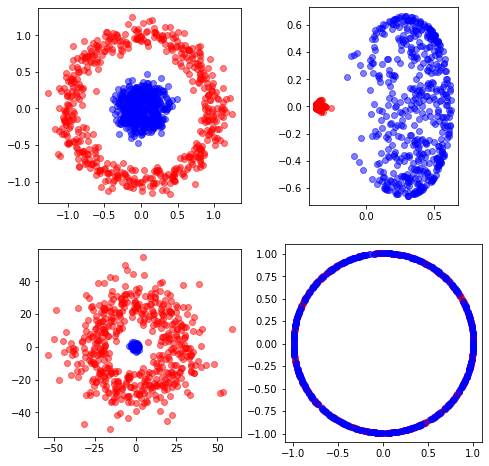

In [ ]:
from sklearn.decomposition import KernelPCA

def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1
    
    plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    kernels_params = [
        dict(kernel='rbf', gamma=10),
        dict(kernel='poly', gamma=10),
        dict(kernel='cosine', gamma=10),
    ]
    
    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_transformed = dec.fit_transform(X)
        
        plt.subplot(rows, cols, i + 2)
        plt.scatter(X_transformed[reds, 0], X_transformed[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_transformed[blues, 0], X_transformed[blues, 1], alpha=0.5, c='b')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        
np.random.seed(54242)
KPCA_show(*make_circles(n_samples=1000, factor=0.2, noise=0.1))

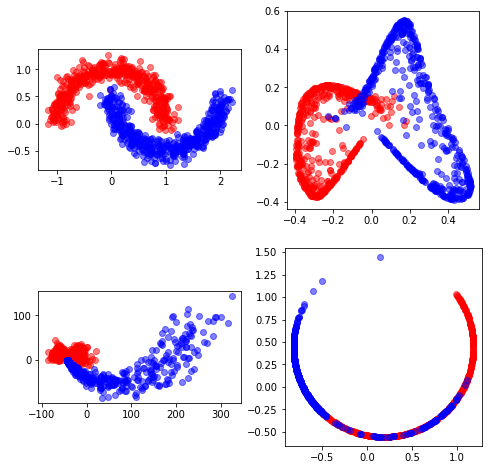

In [ ]:
np.random.seed(54242)
KPCA_show(*make_moons(n_samples=1000, noise=0.1))

# 3. TSNE (t-distributed Stohastic Neighbor Embedding)

Джефри Хинтон не просто сказал слова из эпиграфа к этой тетрадке, но и вместе со своим аспирантом в 2008 г. придумал [новый метод визуализации данных.](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) Основная идея метода состоит в поиске отображения из многомерного признакового пространства на плоскость (или в многомерное пространство меньшей размерности, но почти всегда выбирают 2D), чтобы точки, которые были далеко друг от друга, на плоскости тоже оказались удаленными, а близкие точки также отобразились на близкие. То есть neighbor embedding – это своего рода поиск нового представления данных, при котором сохраняется отношение соседства.

Попробуем взять данные о рукописных цифрах и визуализируем их с помощью PCA. 

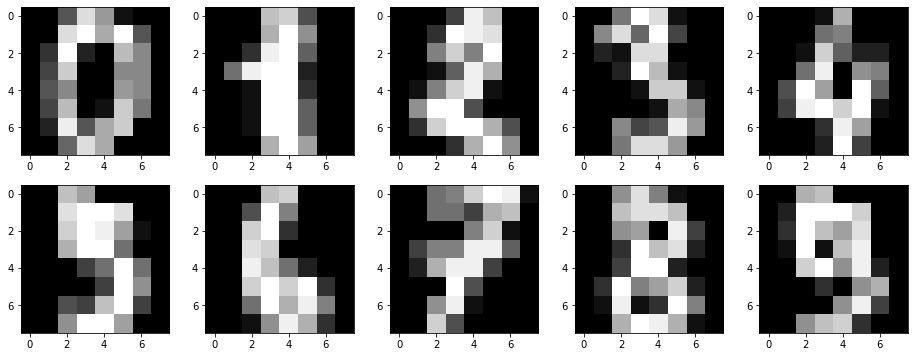

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
y = digits.target

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

In [ ]:
X.shape

(1797, 64)

Получается, размерность признакового пространства здесь 64. Но давайте снизим размерность всего до 2 и увидим, что даже на глаз рукописные цифры неплохо разделяются на кластеры.

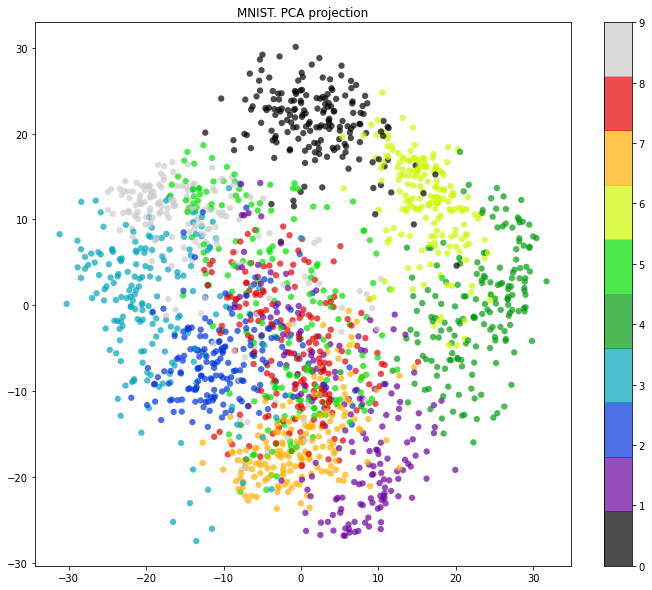

In [ ]:
model_pca = PCA(n_components=2)
X_reduced = model_pca.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

Попробуем сделать то же самое с помощью t-SNE. Картинка получится лучше, так как у PCA есть существенное ограничение: он находит только линейные комбинации исходных признаков, если не добавить какое-нибудь ядро. 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


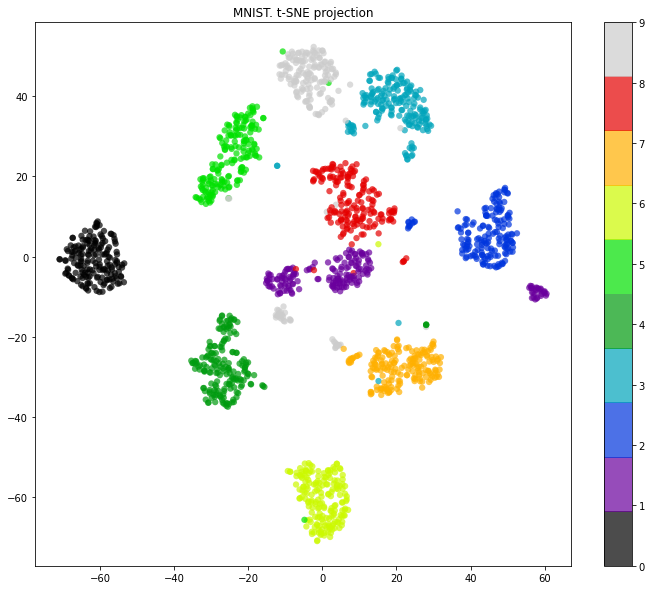

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_jobs=4, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST. t-SNE projection');

У метода есть параметр `Perplexity`, который отвечает за то, насколько сильно точки могут разлететься друг от друга. 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


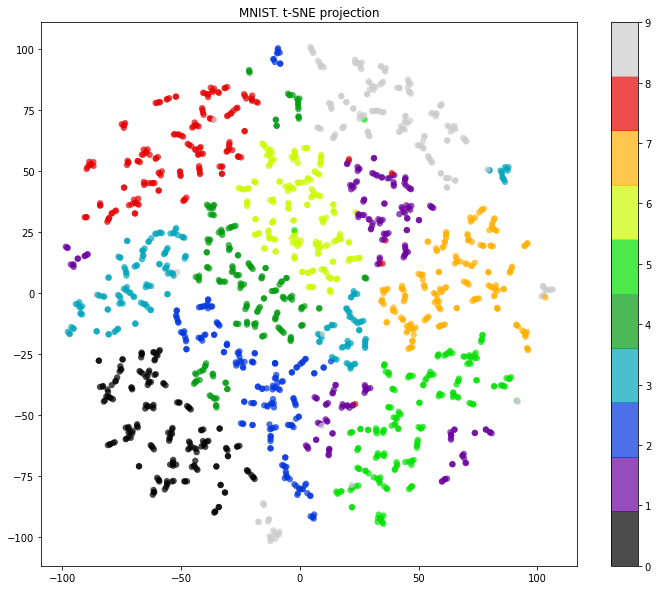

In [ ]:
tsne = TSNE(n_jobs=4, perplexity=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST. t-SNE projection');

Итоговая картинка может сильно поменяться при изменении `random_state`, это усложняет интерпретацию. В целом по таким картинкам не стоит делать далеко идущих выводов – не стоит гадать по кофейной гуще.

В 2018 г. был предложен еще один алгоритм нелинейного снижения размерности — [UMAP.](https://umap-learn.readthedocs.io/en/latest/) Он похож на TSNE, но работает быстрее и более эффективен. 

- [Статья](https://habr.com/ru/company/io/blog/265089/) «Как подобрать платье с помощью метода главных компонент»
- [Q&A Разбор PCA с интуицией и примерами](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
- [Distillpub о TSNE](https://distill.pub/2016/misread-tsne/)
- [Подробнее про UMAP](https://pair-code.github.io/understanding-umap/)

Подведем итоги:
- Отбор признаков не всегда способен снизить размерность нашего пространства, иногда лучше делать это другими способами
- Для линейного снижения размерности используют метод главных компонент. Для его работы желательно нормализовать данные, чтобы масштаб по всем признакам был примерно одинаковый. PCA не учитывает значение целевой переменной
- Для нелинейного снижения размерности обычно используют t-SNE и UMAP. Оба работают достаточно быстро и дают красивые картинки 
- Однако эти нелинейные методы нельзя использовать, чтобы снизить размерность для новой точки. В этом случае лучше подойдут автокодировщики на основе нейронных сетей и другие методы построения представлений данных